In [30]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard as tb
import pandas as pd

In [10]:
sys.path.append(os.path.join(os.getcwd(), "../"))

from models import models
from core.dataset import output_dataset
from core.metrics import TopKThroughputRatio

## Top K accuracy and throughput ratio

In [3]:
eval_filenames = [filename for filename in os.listdir('../../results/eval/')]
max_k = 20

In [4]:
def top_k_eval(filenames, replace_model_str=''):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for filename in filenames:
        with open(f'../../results/eval/{filename}') as file:
            results = json.load(file)

        name = filename.replace('.json', '').replace('-', ' ').replace(replace_model_str, '')
        axs[0].plot(np.arange(max_k), results['top-k-accuracy'][:max_k], label=name)
        axs[1].plot(np.arange(max_k), results['top-k-throughput-ratio'][:max_k], label=name)

    axs[1].legend(title='Models', bbox_to_anchor=(1.05, 1))
    axs[0].set_title('Top K Accuracy')
    axs[1].set_title('Top K Throughput Ratio')
    axs[0].set_xlim(0, 20)
    axs[1].set_xlim(0, 20)
    
    plt.tight_layout()
    return fig, axs

### All

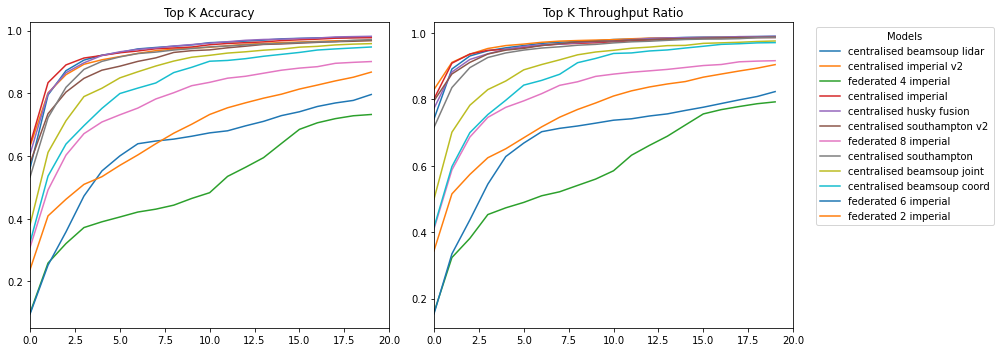

In [5]:
top_k_eval(eval_filenames)
plt.savefig('figs/top-k.png')

### Centralised

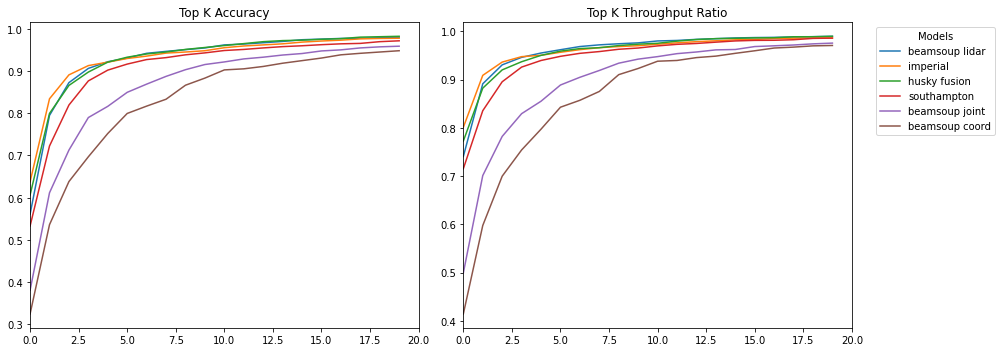

In [6]:
centralised_eval_filenames = [filename for filename in eval_filenames 
                              if 'centralised' in filename and 'v2' not in filename]
top_k_eval(centralised_eval_filenames, 'centralised ')
plt.savefig('figs/centralised-top-k.png')

### Federated

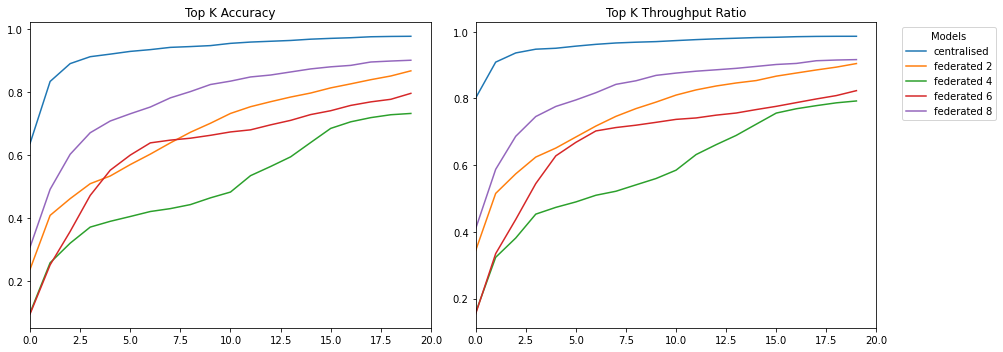

In [23]:
federated_eval_filenames = sorted([filename for filename in eval_filenames 
                                   if 'federated' in filename or filename == 'centralised-imperial.json'])
top_k_eval(federated_eval_filenames, ' imperial')
plt.savefig('figs/federated-top-k.png')

## True output

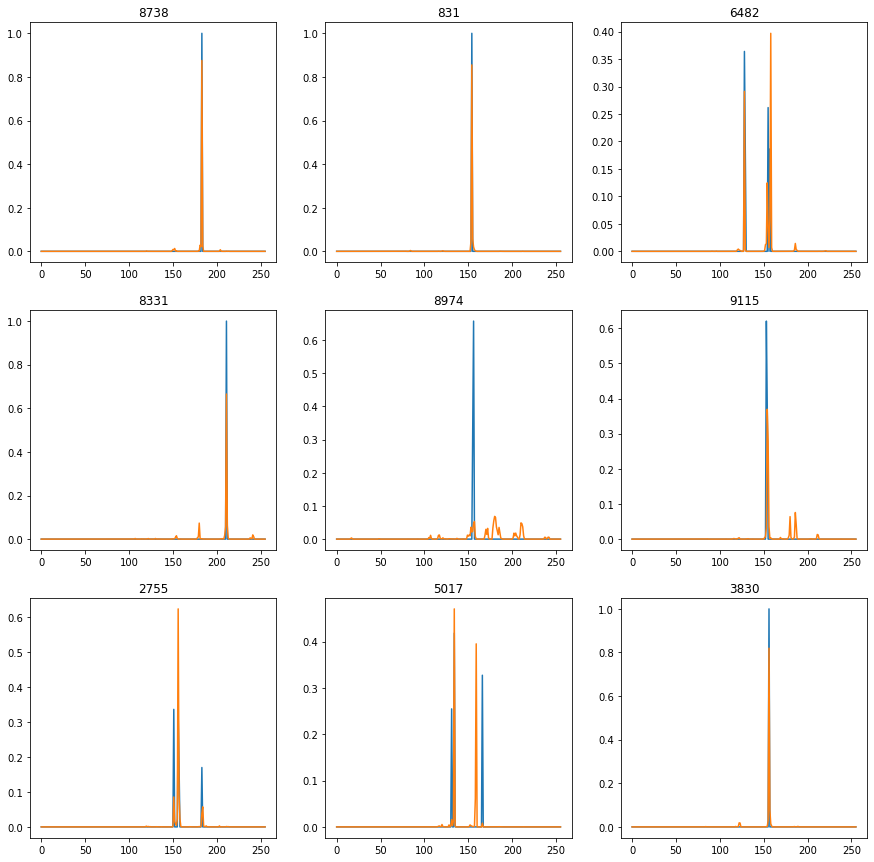

In [13]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('../../results/models/centralised-imperial/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn('../../data')
training_output, validation_output = output_dataset('../../data')

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')
    ax.set_title(pos)

In [16]:
evaluation = model.evaluate(validation_input, validation_output)

62/62 [==============================] - 1s 19ms/step - loss: 1.6653 - top-1-accuracy: 0.6378 - top-10-accuracy: 0.9480 - top-1-throughput: 0.7857 - top-10-throughput: 0.9700


### True output v2

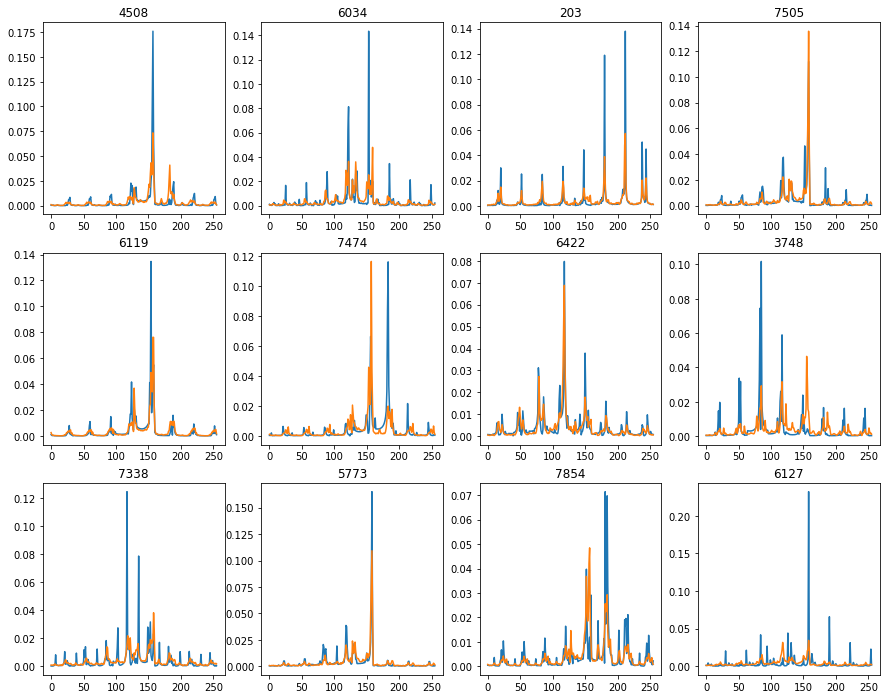

In [20]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('../../results/models/centralised-imperial-v2/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn('../../data')
training_output, validation_output = output_dataset('../../data', version='v2')

fig, axs = plt.subplots(3, 4, figsize=(15, 12))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.set_title(pos)
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')

In [18]:
evaluation = model.evaluate(validation_input, validation_output)

62/62 [==============================] - 2s 20ms/step - loss: 4.4974 - top-1-accuracy: 0.6316 - top-10-accuracy: 0.9444 - top-1-throughput: 0.8119 - top-10-throughput: 0.9743


## Training tensorboard

In [53]:
df = pd.read_csv('../../results/tensorboard-logs.csv')

df

,model-name,setting,metric,step,value
0,centralised-beamsoup-coord,train,loss,0,9.921495
1,centralised-beamsoup-coord,train,loss,1,5.057400
2,centralised-beamsoup-coord,train,loss,2,4.542829
3,centralised-beamsoup-coord,train,loss,3,4.143009
4,centralised-beamsoup-coord,train,loss,4,3.893997
...,...,...,...,...,...
8395,centralised-southampton-v2,validation,top-10-throughput,25,0.971322
8396,centralised-southampton-v2,validation,top-10-throughput,26,0.971043
8397,centralised-southampton-v2,validation,top-10-throughput,27,0.966493
8398,centralised-southampton-v2,validation,top-10-throughput,28,0.970017


In [58]:
def df_setting_values(model, metric, setting):
    return df[(df['model-name'] == model) & (df['metric'] == metric) & (df['setting'] == setting)]['value'].to_numpy()

def plt_tensorboard_logs(models, metrics, setting):
    fig, axs = plt.subplots(1, len(metrics))
    for ax, metric in zip(axs, metrics):
        ax.set_title(metric)
        for model in models:
            ax.plot(np.arange(30), 
                    df[(df['model-name'] == model) & (df['setting'] == setting) &  (df['metric'] == metric)]['value'].to_numpy(),
                    label=model)
        ax.legend()
    fig.suptitle(setting)
    return fig, axs

### Training vs validation over epochs

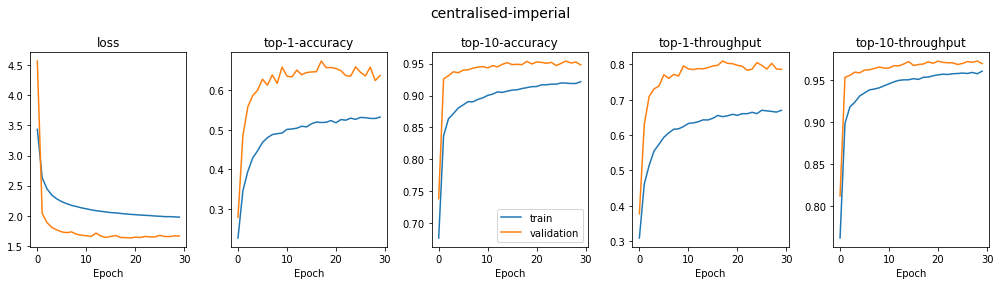

In [68]:
model_name = 'centralised-imperial'

fig, axs = plt.subplots(1, 5, figsize=(14, 4))
fig.suptitle(model_name, fontsize=14)
for ax, metric in zip(axs, pd.unique(df['metric'])):
    ax.set_title(metric)
    ax.plot(np.arange(30), df_setting_values(model_name, metric, 'train'), label='train')
    ax.plot(np.arange(30), df_setting_values(model_name, metric, 'validation'), label='validation')
    ax.set_xlabel('Epoch')
axs[2].legend()
plt.tight_layout()

### Training loss, accuracy and throughput over epochs

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'epoch_loss'}>,
        <AxesSubplot:title={'center':'epoch_top-1-accuracy'}>],
       dtype=object))

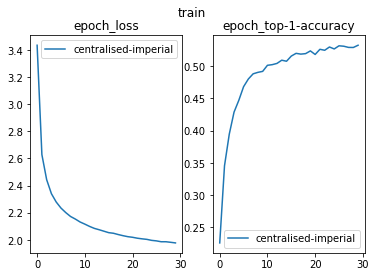

In [52]:
model_names = ['centralised-imperial', 'centralised-']

### Validation loss, accuracy and throughput over epochs